In [ ]:
! pip uninstall pulse2percept -y
! cd pulse2percept && pip install -r requirements.txt && pip install -r requirements-dev.txt && pip install -e .
! pip install tqdm 

In [7]:
! pip install Pillow
! pip install Pandas
! pip install sklearn

# Generating Datasets using python multiprocessing

In [5]:
import pulse2percept as p2p
from prima import * 
%matplotlib inline 
import matplotlib.pyplot as plt 

In [6]:
"""
    utilities for generating percepts for a given model/implant with one stimulus point at each pixel
    of magnitude 10
"""
from tqdm import tqdm 
from multiprocessing import Pool

BASE_CURRENT_CONSTANT = 10

def generate_dataset_helper(argpack):
    model, implant, stim_dim, idx = argpack
    stim = np.zeros(stim_dim)
    stim[idx] = BASE_CURRENT_CONSTANT
    implant.stim = stim
    percept = model.predict_percept(implant)
    return percept

def generate_dataset_fast(model, implant, stim_dim, j=8):
    with Pool(j) as p:
        generator = p.imap(generate_dataset_helper, [(model, implant, stim_dim, idx) for idx in range(0, stim_dim)])
        return list(tqdm(generator, total=stim_dim))


def plot_percept(ax, model, percept, title='Predicted percept'):
    ax.imshow(percept, cmap='gray')
    ax.set_xticks(np.linspace(0, percept.shape[1], num=5))
    ax.set_xticklabels(np.linspace(*model.xrange, num=5))
    ax.set_xlabel('x (dva)')
    ax.set_yticks(np.linspace(0, percept.shape[0], num=5))
    ax.set_yticklabels(np.linspace(*model.yrange, num=5))
    ax.set_ylabel('y (dva)')
    ax.set_title(title)
    

In [7]:
# utility for running PCA on some data 
from sklearn import decomposition
from sklearn import datasets
import numpy as np
import pandas as pd 
from sklearn.preprocessing import *

def run_pca(dataset, percentage=0.95):
    percepts = normalize(np.array([obj.flatten() for obj in dataset]))
    percepts_pca = decomposition.PCA(percentage)
    percepts_pca.fit(percepts)
    components = percepts_pca.transform(percepts)
    projected = percepts_pca.inverse_transform(components)
    return components, projected

## Dataset for AxonMapModel  w/ Argus w/different values of lambda

In [ ]:
#So maybe you could have a separate figure, where you choose a reasonable rho (50um?) 
# and vary only lambda for Argus II. Then plot PCA components vs. lambda for Argus,
# and put up the PCA components from PRIMA (rho=50, scoreboard) as a horizontal dashed line. 
# This should show at what lambda value Argus is worse than PRIMA. Does that make sense?


In [1]:
lambdas = [25, 50, 75, 100, 125, 150, 180, 200, 300]

In [2]:
# rhos = [25, 50, 75, 100, 125, 150, 200, 300]
rhos = [50]

lambda: 25 argus scoreboard
lambda: 50 argus scoreboard
lambda: 75 argus scoreboard
lambda: 100 argus scoreboard
lambda: 125 argus scoreboard
lambda: 150 argus scoreboard
lambda: 200 argus scoreboard
lambda: 300 argus scoreboard


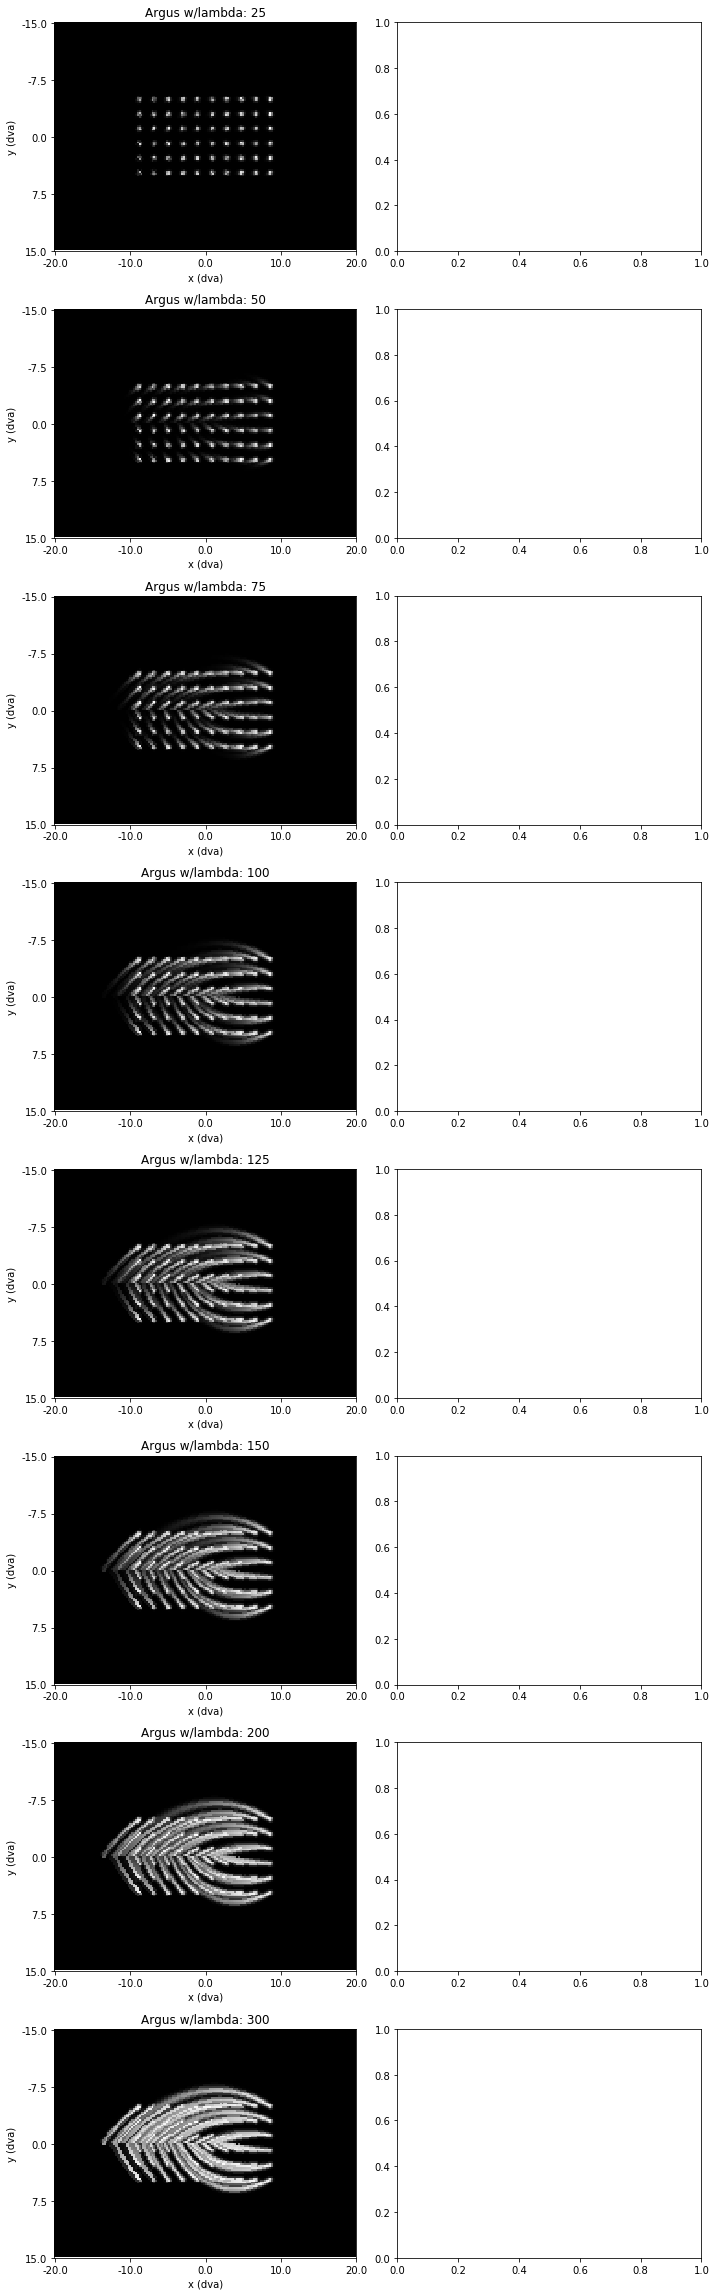

In [10]:
fig, axs = plt.subplots(len(lambdas), 2, constrained_layout=False, figsize=(10, 4 * len(lambdas)))

#
# PLOT THE ARGUSII IMPLANTS FOR VARIOUS VALUES OF LAMBDA USING AXON MODEL 
# SO THAT WE CAN VISUALIZE WHAT CHANGING VALUES FOR LAMBDA DOES
#
for lambda_, (ax_argus, ax_prima) in zip(lambdas, axs):
    model = p2p.models.AxonMapModel(rho=50,axlambda=lambda_)
    model.engine = 'serial'
    model.build()
    
    # simulate ArgusII
    print("lambda: %d argus scoreboard" % lambda_)
    implant = p2p.implants.ArgusII()
    implant.stim = BASE_CURRENT_CONSTANT * np.ones(60)
    
    percept = model.predict_percept(implant)
    plot_percept(ax_argus, model, percept, "Argus w/lambda: %d" % lambda_)
    
#     # simulate ArgusII
#     print("rho: %d prima scoreboard" % rho)
#     implant = Prima()
#     implant.stim = BASE_CURRENT_CONSTANT * np.ones(400)
    
#     percept = model.predict_percept(implant)
#     plot_percept(ax_prima, model, percept, "Prima w/rho: %d" % rho)

fig.tight_layout()

In [11]:
rho = 50
model_p = p2p.models.ScoreboardModel(rho=rho)
model_p.engine = 'serial'
model_p.build()

# simulate Prima
print("rho: %d prima scoreboard" % rho)
implant_p = Prima()
implant_p.stim = BASE_CURRENT_CONSTANT * np.ones(400)

percept_p = model_p.predict_percept(implant_p)
# plot_percept(ax_prima, model, percept, "Prima w/rho: %d" % rho)


rho: 50 prima scoreboard


In [44]:
import gzip
import pickle 
import os 
#
# GENERATE DATASET OF PERCEPTS FROM THE ABOVE PLOTTING
# !! WARNING !! THIS WILL TAKE A VERY LONG TIME ON MOST CPUs
#
basedir = "./data/changing_rho_experiments/"
try:
    os.makedirs(basedir)
except: pass 

print("generating percept sets for values of lambda: " + str(lambdas))
for lambda_ in lambdas:
    model = p2p.models.AxonMapModel(rho=50,axlambda=lambda_)
    model.engine = 'serial'
    model.build()
    
    # simulate ArgusII
    print("lambda: %d argus axonmapmodel" % lambda_)
    if not os.path.exists(os.path.join(basedir, "argus_axonmapmodel_lambda%d.pickle.gz" % lambda_)):
        implant = p2p.implants.ArgusII()
        percepts = generate_dataset_fast(model, implant, 60, j=8)
        with gzip.open(os.path.join(basedir, "argus_axonmapmodel_lambda%d.pickle.gz" % lambda_), "wb") as f:
            pickle.dump(percepts, f)
            
    # simulate AlphaIMS
""" # far to slow to reasonably run
    print("rho: %d alphaims scoreboard" % rho)
    if not os.path.exists(os.path.join(basedir, "alphaims_scoreboard_rho%d.pickle.gz" % rho)):
        implant = p2p.implants.AlphaIMS()
        percepts = generate_dataset_fast(model, implant, 37 ** 2, j=8)
        with gzip.open(os.path.join(basedir, "alphaims_scoreboard_rho%d.pickle.gz" % rho), "wb") as f:
            pickle.dump(percepts, f)
"""
    
    # simulate ArgusII
#     print("rho: %d prima scoreboard" % rho)
#     if not os.path.exists(os.path.join(basedir, "prima_scoreboard_rho%d.pickle.gz" % rho)):
#         implant = Prima()
#         percepts = generate_dataset_fast(model, implant, 400, j=8)
#         with gzip.open(os.path.join(basedir, "prima_scoreboard_rho%d.pickle.gz" % rho), "wb") as f:
#             pickle.dump(percepts, f)


generating percept sets for values of lambda: [25, 50, 75, 100, 125, 150, 180, 200, 300]
lambda: 25 argus axonmapmodel
lambda: 50 argus axonmapmodel
lambda: 75 argus axonmapmodel
lambda: 100 argus axonmapmodel
lambda: 125 argus axonmapmodel
lambda: 150 argus axonmapmodel
lambda: 180 argus axonmapmodel





  0%|          | 0/60 [00:00<?, ?it/s]


  2%|▏         | 1/60 [00:31<30:39, 31.18s/it]


  3%|▎         | 2/60 [00:33<21:43, 22.48s/it]


  5%|▌         | 3/60 [00:34<15:20, 16.14s/it]


  7%|▋         | 4/60 [00:35<10:54, 11.69s/it]


  8%|▊         | 5/60 [00:37<07:48,  8.52s/it]


 10%|█         | 6/60 [00:38<05:41,  6.32s/it]


 12%|█▏        | 7/60 [00:38<04:00,  4.54s/it]


 13%|█▎        | 8/60 [00:40<03:17,  3.81s/it]


 15%|█▌        | 9/60 [01:02<07:48,  9.19s/it]


 17%|█▋        | 10/60 [01:04<05:48,  6.96s/it]


 18%|█▊        | 11/60 [01:06<04:25,  5.42s/it]


 20%|██        | 12/60 [01:07<03:22,  4.22s/it]


 22%|██▏       | 13/60 [01:08<02:35,  3.31s/it]


 23%|██▎       | 14/60 [01:09<02:01,  2.65s/it]


 25%|██▌       | 15/60 [01:10<01:36,  2.15s/it]


 27%|██▋       | 16/60 [01:11<01:19,  1.80s/it]


 28%|██▊       | 17/60 [01:32<05:27,  7.61s/it]


 30%|███       | 18/60 [01:34<04:07,  5.90s/it]


 32%|███▏      | 19/60 [01:36<03:09,  4.61s/it]


 33%|███▎      

lambda: 200 argus axonmapmodel
lambda: 300 argus axonmapmodel


' # far to slow to reasonably run\n    print("rho: %d alphaims scoreboard" % rho)\n    if not os.path.exists(os.path.join(basedir, "alphaims_scoreboard_rho%d.pickle.gz" % rho)):\n        implant = p2p.implants.AlphaIMS()\n        percepts = generate_dataset_fast(model, implant, 37 ** 2, j=8)\n        with gzip.open(os.path.join(basedir, "alphaims_scoreboard_rho%d.pickle.gz" % rho), "wb") as f:\n            pickle.dump(percepts, f)\n'

In [8]:
import pickle
import os 
import gzip 
# 
# GENERATE PLOT OF THE PCA DATA
#
basedir = "./data/changing_rho_experiments/"
try:
    os.makedirs(basedir)
except: pass 
percent = 0.95
rho = 50
argus_pca_shapes = []
prima_pca_shapes = []
for lambda_ in lambdas:
    argus_percepts_path = os.path.join(basedir, "argus_axonmapmodel_lambda%d.pickle.gz" % lambda_)
#     prima_percepts_path = os.path.join(basedir, "prima_scoreboard_rho%d.pickle.gz" % rho)
    with gzip.open(argus_percepts_path, "rb") as f:
        argus_percepts = pickle.load(f)
    print("loaded argus percepts for lambda %d, size: %s" % (lambda_, str(np.array(argus_percepts).shape)))
#     with gzip.open(prima_percepts_path, "rb") as f:
#         prima_percepts = pickle.load(f)
#     print("loaded prima percepts for rho %d, size: %s" % (rho, str(np.array(prima_percepts).shape)))
    
    argus_pca_components, _ = run_pca(argus_percepts, percent)
    argus_pca_shapes.append(argus_pca_components.shape)
    print("\targus pca shape: " + str(argus_pca_components.shape))

prima_percepts_path = os.path.join(basedir, "prima_scoreboard_rho%d.pickle.gz" % rho)
with gzip.open(prima_percepts_path, "rb") as f:
    prima_percepts = pickle.load(f)
print("loaded prima percepts for rho %d, size: %s" % (rho, str(np.array(prima_percepts).shape)))

prima_pca_components, _ = run_pca(prima_percepts, percent)
prima_pca_shapes.append(prima_pca_components.shape)
print("\tprima pca shape: " + str(prima_pca_components.shape))

loaded argus percepts for lambda 25, size: (60, 124, 164)
	argus pca shape: (60, 57)
loaded argus percepts for lambda 50, size: (60, 124, 164)
	argus pca shape: (60, 56)
loaded argus percepts for lambda 75, size: (60, 124, 164)
	argus pca shape: (60, 55)
loaded argus percepts for lambda 100, size: (60, 124, 164)
	argus pca shape: (60, 53)
loaded argus percepts for lambda 125, size: (60, 124, 164)
	argus pca shape: (60, 52)
loaded argus percepts for lambda 150, size: (60, 124, 164)
	argus pca shape: (60, 51)
loaded argus percepts for lambda 180, size: (60, 124, 164)
	argus pca shape: (60, 50)
loaded argus percepts for lambda 200, size: (60, 124, 164)
	argus pca shape: (60, 49)
loaded argus percepts for lambda 300, size: (60, 124, 164)
	argus pca shape: (60, 48)
loaded prima percepts for rho 50, size: (400, 124, 164)
	prima pca shape: (400, 332)


[332]
[57, 56, 55, 53, 52, 51, 50, 49, 48]


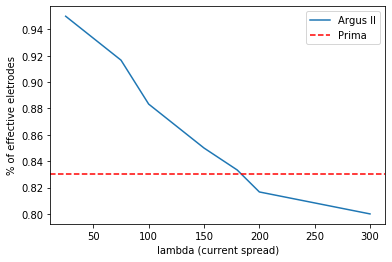

In [9]:
print([v[1] for v in prima_pca_shapes])
print([v[1] for v in argus_pca_shapes])
zeros = [0]*len(lambdas)
plt.plot(lambdas, [v[1]/60 for v in argus_pca_shapes],label="Argus II")
# plt.plot(zeros, [v[1]/400 for v in argus_pca_shapes],label="Prima")
plt.axhline(prima_pca_shapes[0][1]/400, color='r', linestyle='--',label="Prima")
plt.ylabel("% of effective eletrodes")
plt.xlabel("lambda (current spread)")
# plt.title("Prima vs. Argus: PCA Components With Changing Lambda")
plt.legend()
# plt.legend(("Argus II", "Prima"))